# STEP 1

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

100.0%
100.0%
100.0%
100.0%


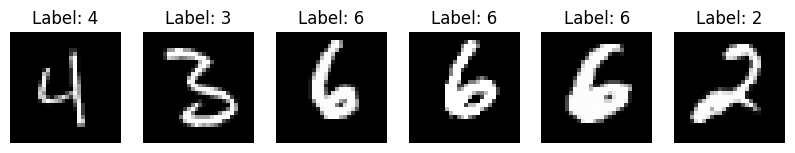

In [2]:
# Trasformazione per convertire le immagini in tensor e normalizzarle
transform = transforms.Compose([
    transforms.ToTensor()
])

# Scarica MNIST (70k immagini) – la prima volta può metterci un po'
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# DataLoader per iterare facilmente sui dati
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Mostra un batch di immagini
examples = enumerate(train_loader)
batch_idx, (images, labels) = next(examples)

# Visualizza le prime 6 immagini
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()


# STEP 2

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Definizione della rete neurale MLP
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classi: da 0 a 9

    def forward(self, x):
        x = x.view(-1, 28*28)       # Flatten dell'immagine
        x = F.relu(self.fc1(x))     # Primo strato
        x = F.relu(self.fc2(x))     # Secondo strato
        x = self.fc3(x)             # Output grezzo
        return x

In [5]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Allenamento per 1 epoca (puoi aumentare a 5 o 10)
for epoch in range(1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 327.4969


In [6]:
correct = 0
total = 0
model.eval()  # Disattiva dropout/batchnorm (non usati qui, ma buona pratica)

with torch.no_grad():
    for images, labels in torch.utils.data.DataLoader(test_dataset, batch_size=64):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 94.65%


# STEP 3 - Single image attack

In [7]:
# 1. Funzione di attacco FGSM
def fgsm_attack(image, epsilon, data_grad):
    """
    Applica l'attacco FGSM all'immagine.
    
    image:      immagine originale (tensor)
    epsilon:    quantità di rumore da aggiungere
    data_grad:  gradiente della loss rispetto all'immagine
    """
    # Prende il segno del gradiente: solo direzione, non valore
    sign_data_grad = data_grad.sign()
    
    # Aggiunge il rumore all'immagine originale
    perturbed_image = image + epsilon * sign_data_grad

    # Clippa i valori per restare tra 0 e 1 (limite immagine)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image


In [8]:
epsilon = 0.2  # quanto rumore vuoi aggiungere (es. 0.1 = lieve, 0.3 = forte)


Initial prediction: 7
Prediction after attack: 3


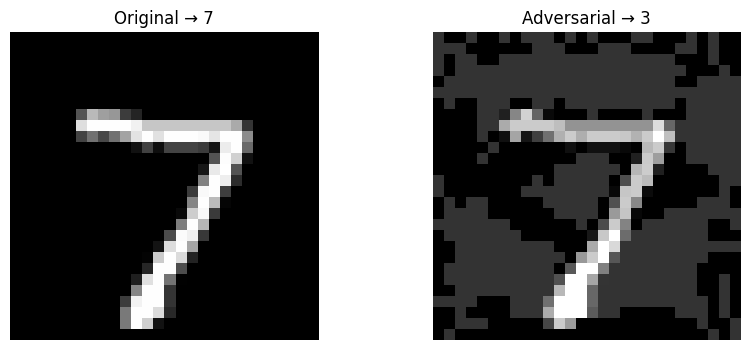

In [9]:
# Troviamo un esempio che il modello classifica correttamente
model.eval()

# Carichiamo una sola immagine e label vera
image, label = test_dataset[0]
image = image.unsqueeze(0)  # aggiunge dimensione batch: [1, 1, 28, 28]
label = torch.tensor([label])  # label come tensor

# Abilita il calcolo del gradiente sull'immagine
image.requires_grad = True

# Inference: calcolo dell’output
output = model(image)
init_pred = output.max(1, keepdim=True)[1]  # classe predetta

print("Initial prediction:", init_pred.item())

# Se la predizione è sbagliata, salta (non ha senso attaccare)
if init_pred.item() != label.item():
    print("Modello già sbaglia, skip")
else:
    # Calcola la loss normale
    loss = criterion(output, label)

    # Backprop per calcolare il gradiente della loss rispetto all'immagine
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    # Applica l'attacco FGSM
    perturbed_data = fgsm_attack(image, epsilon, data_grad)

    # Rilancia la predizione sul dato modificato
    output_perturbed = model(perturbed_data)
    final_pred = output_perturbed.max(1, keepdim=True)[1]

    print("Prediction after attack:", final_pred.item())

    # Visualizzazione
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().detach().numpy(), cmap="gray")
    plt.title(f"Original → {init_pred.item()}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_data.squeeze().detach().numpy(), cmap="gray")
    plt.title(f"Adversarial → {final_pred.item()}")
    plt.axis('off')
    plt.show()


# STEP 4 - Mass attack

In [10]:
epsilon = 0.2  # quanto "rumore" avversario vuoi aggiungere (già usato prima)


In [11]:
correct = 0
adv_examples = []

# Usiamo un nuovo dataloader per iterare sul test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Disattiva modalità training
model.eval()

# Loop su tutte le immagini del test set
for data, target in test_loader:
    data.requires_grad = True  # attiviamo il gradiente

    # Predizione iniziale
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]

    # Se la predizione è già sbagliata, saltiamo
    if init_pred.item() != target.item():
        continue

    # Calcolo della loss e backward
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    # Applica l'attacco FGSM
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    # Rilancia la predizione sull'immagine modificata
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]

    if final_pred.item() == target.item():
        correct += 1  # ancora corretto → bravo modello
    else:
        # salviamo un esempio adversariale (massimo 5)
        if len(adv_examples) < 5:
            adv_examples.append( (init_pred.item(), final_pred.item(), perturbed_data.squeeze().detach()) )

# Calcola nuova accuracy
final_acc = correct / float(len(test_loader)) * 100
print(f"Test Accuracy under FGSM Attack (ε={epsilon}): {final_acc:.2f}%")


Test Accuracy under FGSM Attack (ε=0.2): 0.16%


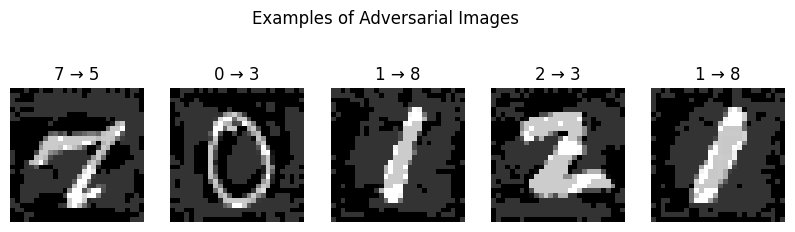

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
for i, (orig, adv, img) in enumerate(adv_examples):
    plt.subplot(1, 5, i+1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.title(f"{orig} → {adv}")
    plt.axis('off')
plt.suptitle("Examples of Adversarial Images")
plt.show()
